# 1. Import Modules

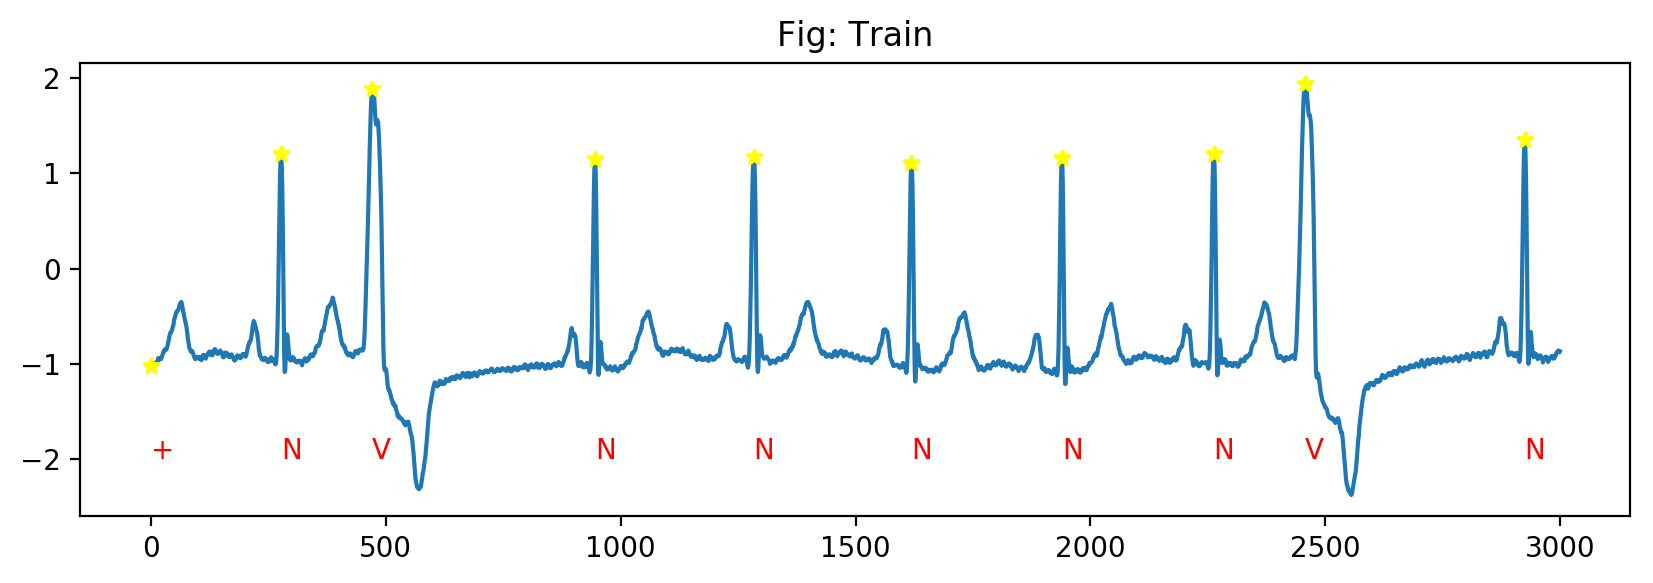

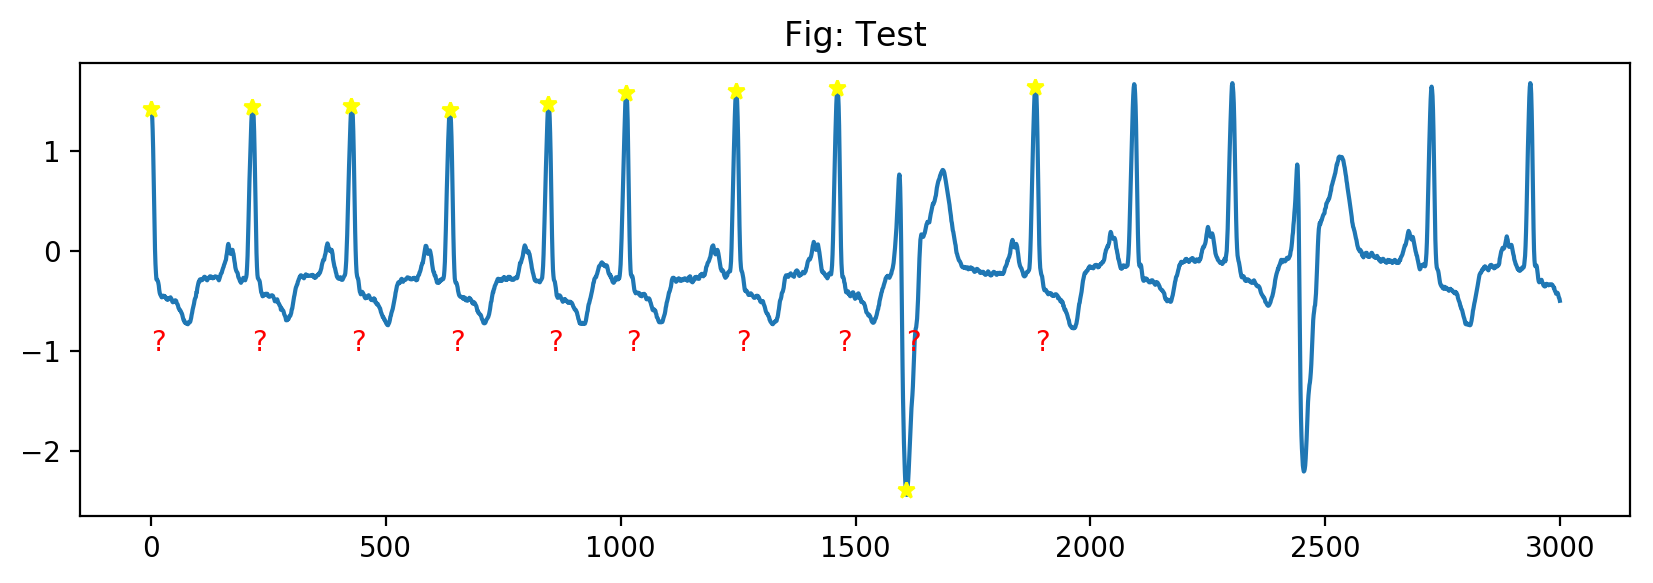

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os,time,math
from IPython.display import display

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import auc, roc_curve
from scipy.fftpack import fft

import wfdb
from wfdb import processing



def read_ecg(file_path, ann_extension = 'atr'):
    """
    output: ecg files, get signal, annotated peaks, annotated types
    input: ecg file id
    """
    signals, fields = wfdb.rdsamp(file_path)
    annotation = wfdb.rdann(file_path,ann_extension)
    ecg_sig = signals[:,0]
    ecg_type = annotation.symbol
    ecg_peak = annotation.sample
    return ecg_sig, ecg_type, ecg_peak, fields



def plot_ecg(ecg_sig, ecg_type, ecg_peak, title='Fig: Train', st = 0,npeak=10,len_sig=3000, ann_loc = -1):
    """
    demo plot ecg signal with annotated peaks, annotated types
    """
    plt.rcParams['figure.dpi'] = 200
    _, ax = plt.subplots(figsize=(10, 3))
    loc_st = ecg_peak[st]
    for i in range(st, st+npeak):
        ax.annotate(ecg_type[i], xy=(ecg_peak[i]-loc_st,ann_loc),color = 'red')
    ax.plot(ecg_sig[loc_st:loc_st+len_sig])
    ax.plot(ecg_peak[st:st+npeak]-loc_st, ecg_sig[ecg_peak[st:st+npeak]], '*',color = 'yellow')
    ax.set_title(title)

# display a training sample    
ecg_sig, ecg_type, ecg_peak,_ = read_ecg('./database/train/a4')
plot_ecg(ecg_sig, ecg_type, ecg_peak, st = 0, npeak=10, ann_loc = -2)

# display a testing sample
ecg_sig, ecg_type, ecg_peak,_ = read_ecg('./database/test/b2')
plot_ecg(ecg_sig, ecg_type, ecg_peak, st = 30, title='Fig: Test', npeak=10)

# 2. Feature Engineering

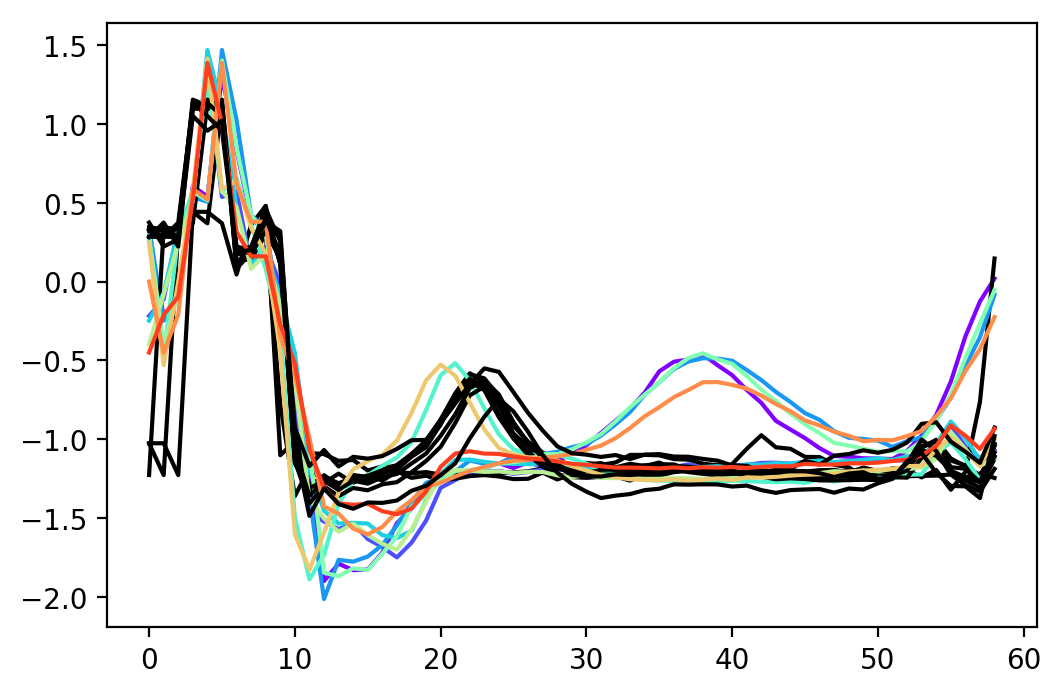

In [2]:
def feature_extract(files, folder = 'train', resample_freq = 50, corr = False, refs = None, n_train = 200):
    """
    1) Scale and calculate interval and intensity for peaks in consecutive 3 segments; 
    2) Resample each segment to a frequency of 50;
    3) Calculate pearson coefficient of each segment with given referencing ECG series.
    Aggregate them as features.
    """
    
    def resample(seg,resample_freq):
        if len(seg) < resample_freq: # fill zeros
            seg = list(seg)
            seg += [seg[-1]]*resample_freq
            seg = seg[:resample_freq]
        new_sig = processing.resample_sig(np.array(seg),len(seg),resample_freq)[0]
        return list(new_sig) 
    
    def corr_coefs(seg, refs):
        return [np.corrcoef(seg,refs[i])[0][-1] for i in range(len(refs))]
    
    def process_seg(new_seg,resample_freq,corr, refs):      
        seg_max, seg_min, seg_med = np.max(new_seg), np.min(new_seg), np.median(new_seg)
        dev =  np.abs(seg_min-seg_med)
        r1 = 1.*sum(np.array(new_seg)-seg_med - 0.1*(seg_max - seg_med) > 0)/len(new_seg)
        r2 = 1.*sum(np.array(new_seg)-seg_med - 0.1*(seg_min - seg_med) < 0)/len(new_seg)
        row = [dev,r1,r2] + new_seg
        if corr:
            row += corr_coefs(np.array(new_seg), refs)
        return row
    
    features, labels = [],[]
    for f in files:        
        file_path = './database/{}/'.format(folder) + f
        ecg_sig, ecg_type, ecg_peak,_ = read_ecg(file_path)        
        f_features, f_labels = [], ecg_type
        f_labels = np.array([1 if tp == 'V' else 0 for tp in f_labels]).astype(int)
        
        if folder == 'train':
            # Select only first 200 positive segments and 200 negative segments from each training sample 
            if np.where(f_labels == 1)>n_train:
                pos = np.where(f_labels == 1)[0][:n_train]
                neg = np.where(f_labels == 0)[0][:n_train]
            # Select all segments in testing sample     
            else:
                pos = np.where(f_labels == 1)[0]
                neg = np.where(f_labels == 0)[0][:len(pos)]
            choices = list(pos)+list(neg)
        else:
            choices = list(range(len(f_labels)))
            
        # Normalize using median
        sig_intensity = ecg_sig[ecg_peak]
        intervals = np.array(list(ecg_peak[1:])+[ecg_peak[-1]]) - ecg_peak        
        int_med, post_med = np.median(sig_intensity), np.median(intervals)
        sig_intensity, intervals = (sig_intensity-int_med)/int_med, intervals/post_med
        
        for i in choices:
            st = ecg_peak[i]
            if i == len(ecg_peak)-1:
                ed = len(ecg_sig)
            else:
                ed = ecg_peak[i+1]
                
            seg = (ecg_sig[st:ed]-int_med)/int_med
            new_seg = resample(seg,resample_freq)       
            pre_loc,post_loc = max(i-1,0),min(len(ecg_peak)-1,i+1)
            pre_int, cur_int, post_int = sig_intensity[pre_loc], sig_intensity[i], sig_intensity[post_loc]
            pre_inv, cur_inv, post_inv = intervals[pre_loc], intervals[i], intervals[post_loc]
            row = [pre_int, cur_int, post_int, pre_inv, cur_inv, post_inv]+list(process_seg(new_seg,resample_freq,corr, refs))
            f_features.append(row) 
        
        features.append(np.array(f_features))
        labels += list(f_labels[choices])
        
    features,labels = np.vstack(features),np.array(labels)
#     print features.shape, labels.shape    
    return features,labels


    
def display_ROC(X_train, y_train, X_test, y_test):
    """
    Display performance of model using AUC score and ROC curve. (Note the training data 
    and testing data are from different samples instead of normal StratifiedKFold blend 
    to avoid leaking to model the individual specific information.)
    """
    colors = ['purple','red','pink']
    baseline_prob = [LogisticRegression(),KNeighborsClassifier(),GradientBoostingClassifier()]

    rocauc_results = {}    
    for clf in baseline_prob:
        bgn = time.time() 
        clf_name = clf.__class__.__name__
        rocauc_results[clf_name] = {'auc':0,'fpr':[],'tpr':[]}

        clf.fit(X_train,y_train)
        rocauc_results[clf_name]['fpr'],rocauc_results [clf_name]['tpr'],_ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
        rocauc_results[clf_name]['auc'] = auc(rocauc_results[clf_name]['fpr'], rocauc_results [clf_name]['tpr'])
        end = time.time()
        print clf_name + " AUC score:",rocauc_results[clf_name]['auc'], " Time: " + str(end - bgn)

    plt.figure(figsize=(5,3))
    plt.plot([0, 1], [0, 1], color='navy',linestyle='--')

    for i,name in enumerate(rocauc_results.keys()):
        plt.plot(rocauc_results[name]['fpr'], rocauc_results[name]['tpr'], color=colors[i],label='{} (area = {:.2f})'.format(name,rocauc_results[name]['auc']))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])

    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('ROC Curve(Baseline)');
    plt.legend(loc="lower right");      

    
    
# Generate references for pearson coefficients calculation 

# a3 is chosen as reference for b2 as they are both recorded as multiform PVC
features, labels = feature_extract(['a3'], folder = 'train')

pos = list(np.where(labels == 1)[0][:10])
neg = list(np.where(labels == 0)[0][:10])
refs = features[pos+neg] 
refs = refs[:,-50:]


# Graphical comparision of positive and negative segments in references
from matplotlib.pyplot import cm
colors = cm.rainbow(np.linspace(0,5,50))
for i in range(min(10,len(pos))):     
    plt.plot(features[pos[i]],c = colors[i%50])
    plt.plot(features[neg[i]],c = 'black')    

# 3. Performance Display

test on:  a3
LogisticRegression AUC score: 0.9962  Time: 0.873677015305
KNeighborsClassifier AUC score: 0.9997  Time: 0.181416988373
GradientBoostingClassifier AUC score: 0.999525  Time: 4.81171584129
test on:  a4
LogisticRegression AUC score: 1.0  Time: 0.868371009827
KNeighborsClassifier AUC score: 0.99725  Time: 0.278292894363
GradientBoostingClassifier AUC score: 1.0  Time: 4.88549494743
test on:  a6
LogisticRegression AUC score: 0.998201219512  Time: 0.882186174393
KNeighborsClassifier AUC score: 1.0  Time: 0.0944619178772
GradientBoostingClassifier AUC score: 0.99993902439  Time: 4.64227795601


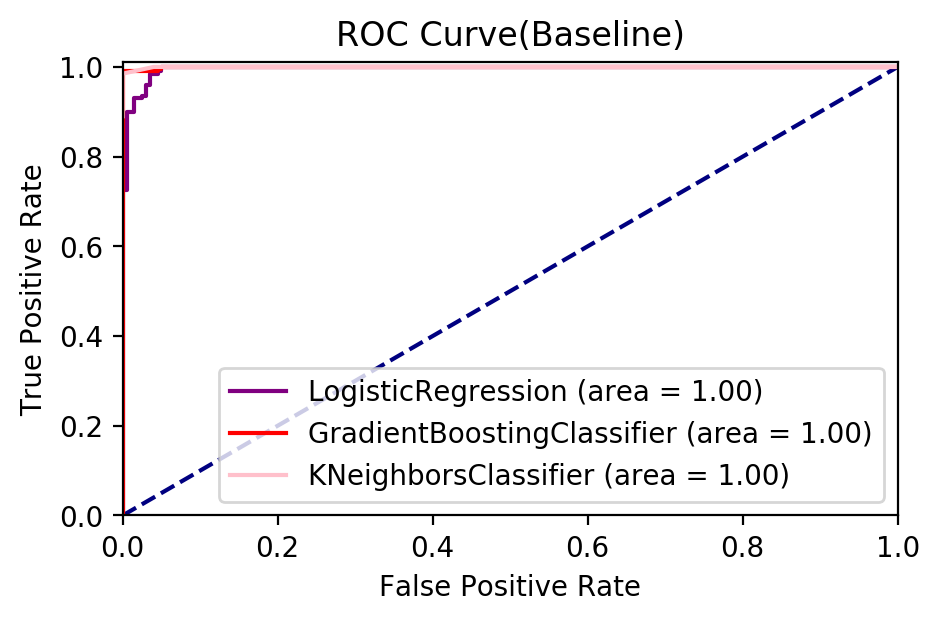

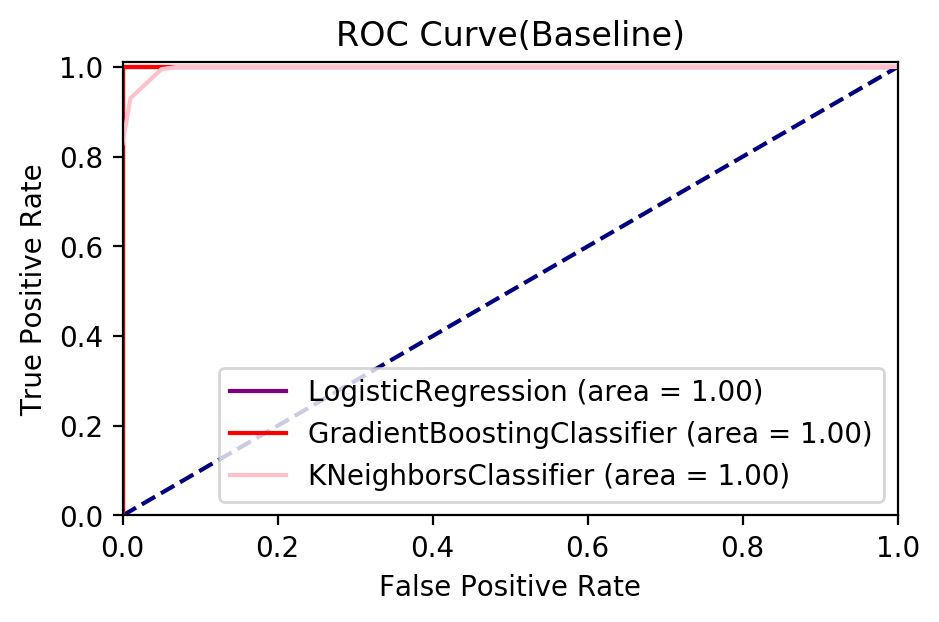

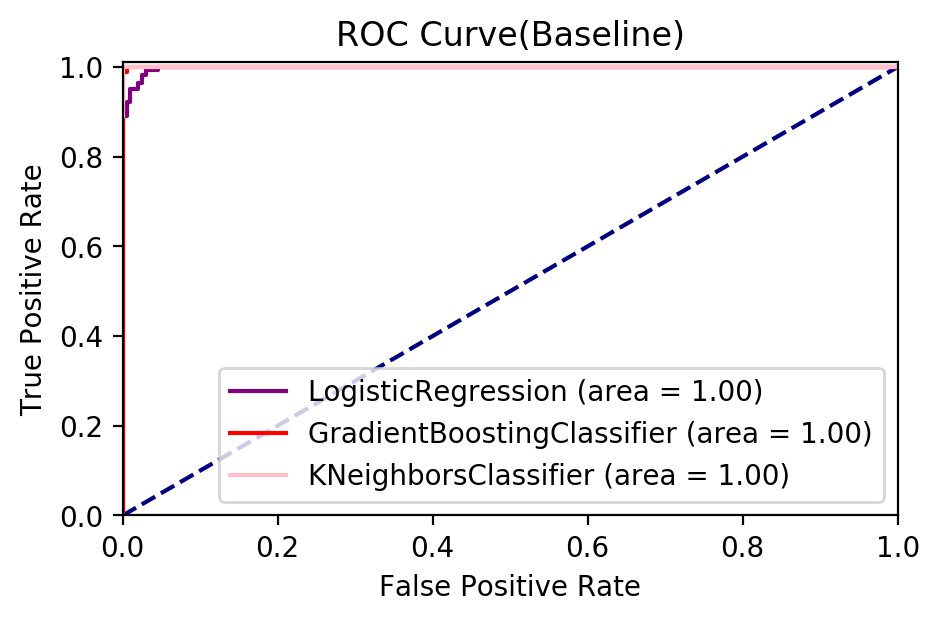

In [3]:
files = os.listdir('./database/train')
files = [f.split('.')[0] for f in files if f.split('.')[-1] == 'dat']


# Notice:
# 1) a1, a2, a5 is highly imbalanced (mostly negatives), 
# thus not used for performance testing
# 2) files used in training and testing are separted instead
# of from StratifiedKFold blending 

for f in ['a3','a4','a6']:
    train_files = [x for x in files if x != f]
    X, y = feature_extract(train_files,corr=True, refs = refs)
    X_test, y_test = feature_extract([f],corr=True, refs = refs)
    print 'test on: ',f
    display_ROC(X, y, X_test, y_test)

# 4. Predictions

    
    
## 1) b2    

In [4]:
X, y = feature_extract(files, corr=True, refs = refs)

X_test, _ = feature_extract(['b2'], folder = 'test',corr=True, refs = refs)
pred_y = LogisticRegression().fit(X,y).predict(X_test)

# Tentative performance testing
human_ann30 = [1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0]
np.where(~(pred_y[:30] == human_ann30))[0]

array([23, 26])

In [5]:
_, _, ecg_peak, fields = read_ecg('./database/test/b2')
display(fields)

wfdb.wrann('b2', 'test', ecg_peak, ['V' if py == 1 else '?' for py in pred_y], write_dir='./database/test/')

{'base_date': None,
 'base_time': None,
 'comments': ['57 M 1682 654 x2', 'Dilantin', 'The PVCs are multiform.'],
 'fs': 360,
 'n_sig': 2,
 'sig_len': 650000,
 'sig_name': ['MLII', 'V1'],
 'units': ['mV', 'mV']}

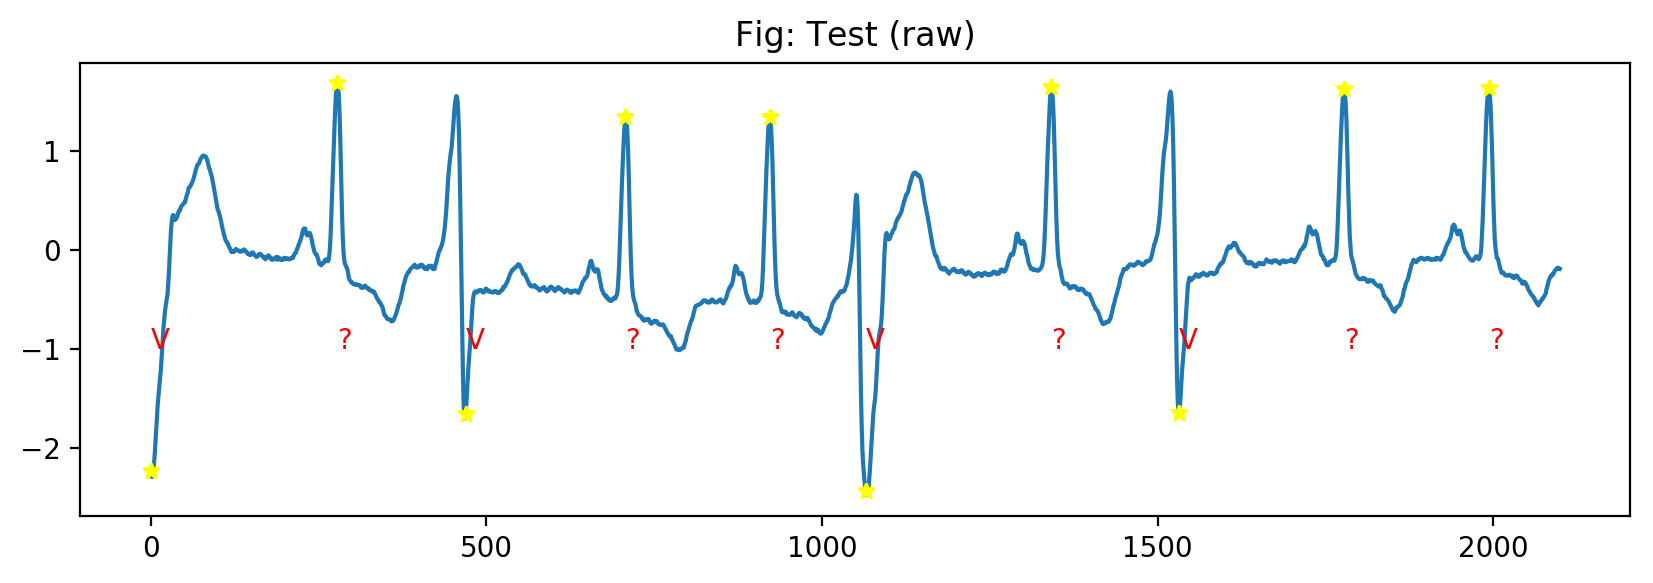

In [6]:
testing_file_path = './database/test/b2'
ecg_sig, ecg_type, ecg_peak,_ = read_ecg(testing_file_path,'test')
plot_ecg(ecg_sig, ecg_type, ecg_peak, title='Fig: Test (raw)', st=0,len_sig=2100)

## 2) b1

In [7]:
# 228 is chosen as reference for b1 as they both have first degree AV block
features, labels = feature_extract(['228'], folder = 'train')

pos = list(np.where(labels == 1)[0][:10])
neg = list(np.where(labels == 0)[0][:10])
refs = features[pos+neg] 
refs = refs[:,-50:]

files = ['108','109','111','222','228','231'] 

X, y = feature_extract(files, corr=True, refs = refs, n_train = 1000)

X_test, _ = feature_extract(['b1'], folder = 'test',corr=True, refs = refs,n_train = 1000)
pred_y = LogisticRegression().fit(X,y).predict(X_test)

# # Tentative performance testing
sum(pred_y)

46

In [10]:
_, _, ecg_peak, fields = read_ecg('./database/test/b1')
display(fields)

wfdb.wrann('b1', 'test', ecg_peak, ['V' if py == 1 else '?' for py in pred_y], write_dir='./database/test/')

{'base_date': None,
 'base_time': None,
 'comments': ['80 F 2775 1629 x1',
  'Digoxin, Norpace',
  'There is first degree AV block.  The PVCs are multiform.  There are',
  'three short occurrences of tape slippage with a maximum duration of 2.2',
  'seconds.'],
 'fs': 360,
 'n_sig': 2,
 'sig_len': 650000,
 'sig_name': ['MLII', 'V1'],
 'units': ['mV', 'mV']}

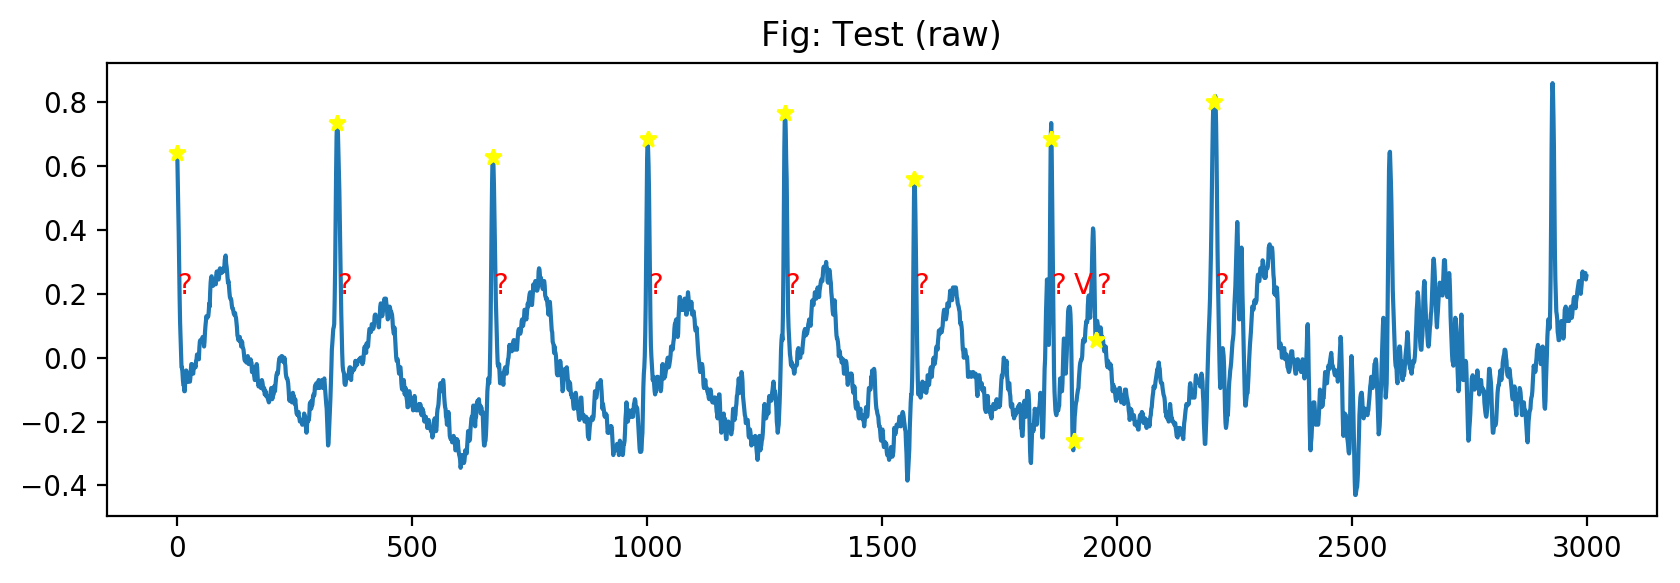

In [13]:
testing_file_path = './database/test/b1'
ecg_sig, ecg_type, ecg_peak,_ = read_ecg(testing_file_path,'test')
plot_ecg(ecg_sig, ecg_type, ecg_peak, title='Fig: Test (raw)', st=50,ann_loc = 0.2,len_sig=3000)